In [1]:
import os

import fsspec
import morphsnakes as ms
import numpy as np
import pystac
import rasterio
import rioxarray
import stac2dcache

import matplotlib.pyplot as plt

from dhdt.generic.mapping_tools import pix2map
from dhdt.input.read_sentinel2 import \
    list_central_wavelength_msi, \
    read_detector_mask, read_view_angles_s2, read_sun_angles_s2, \
    read_mean_sun_angles_s2, s2_dn2toa
from dhdt.preprocessing.shadow_transforms import \
    entropy_shade_removal
from dhdt.preprocessing.shadow_geometry import shadow_image_to_list
from dhdt.postprocessing.solar_tools import \
    make_shading, make_shadowing
from dhdt.preprocessing.acquisition_geometry import \
    get_template_aspect_slope, compensate_ortho_offset
from dhdt.processing.coupling_tools import match_pair
from dhdt.processing.matching_tools import \
    get_coordinates_of_template_centers

In [2]:
BOI = ["red", "green", "blue", "nir"]
WINDOW_SIZE = 2**4

In [3]:
MACAROON_PATH = "./macaroon.dat"

CATALOG_URL = "https://webdav.grid.surfsara.nl:2880/pnfs/grid.sara.nl/data/eratosthenes/disk/red-glacier_shadows"
DEM_URL = "https://webdav.grid.surfsara.nl:2880/pnfs/grid.sara.nl/data/eratosthenes/disk/CopernicusDEM_tiles_sentinel-2/COP-DEM-05VMG.tif"

BBOX = [490229, 6642656, 516134, 6660489]
SHADE_REMOVAL_ANGLE = 138

ITEM_ID = "S2_2020-10-19"

WORK_DIR = "./"

In [4]:
def _read_catalog(urlpath, stac_io=None):
    """
    Read STAC catalog from URL/path

    :param urlpath: URL/path to the catalog root
    :param stac_io (optional): STAC IO instance to read the catalog
    :return: PyStac Catalog object
    """
    urlpath = urlpath \
        if urlpath.endswith("catalog.json") \
        else f"{urlpath}/catalog.json"
    catalog = pystac.Catalog.from_file(urlpath, stac_io=stac_io)
    return catalog


def _open_raster_file(urlpath, filesystem=None, bbox=None, load=True):
    """
    Open a raster file from its URL/path as a single-band DataArray
    
    :param urlpath: URL/path to the file
    :param filesystem: filesystem object where to read the file
    :return: file object
    """
    da = rioxarray.open_rasterio(urlpath, mask_and_scale=True)
    if bbox is not None:
        da = da.rio.slice_xy(*bbox)
    if load:
        da.load()
    return da.squeeze()


def _copy_file_to_local(urlpath_from, path_to, filesystem=None):
    """
    Copy file from URL/path to (local) path
    
    :param urlpath_from: URL/path to the file
    :param path_to: destination path
    :param filesystem: filesystem instance to read the file
    """
    if filesystem is None:
        filesystem = fsspec.get_filesystem_class(url)()
    filesystem.get(urlpath_from, path_to)
    _, filename = os.path.split(urlpath_from)
    return os.path.join(path_to, filename)


def _get_bbox_indices(x, y, bbox):
    """
    Convert bbox values to array indices

    :param x: array with the X coordinates
    :param y: array with the Y coordinates
    :param bbox: minx, miny, maxx, maxy values
    :return: bbox converted to array indices
    """
    minx, miny, maxx, maxy = bbox
    xindices, = np.where((x >= minx) & (x <= maxx))
    yindices, = np.where((y >= miny) & (y <= maxy))
    return yindices[0], yindices[-1]+1, xindices[0], xindices[-1]+1

In [5]:
s2_df = list_central_wavelength_msi()
s2_df = s2_df[s2_df['common_name'].isin(BOI)]

In [6]:
# configure connection to dCache
stac2dcache.configure(token_filename=MACAROON_PATH)

In [7]:
# read catalog and extract item
catalog = _read_catalog(CATALOG_URL, stac2dcache.stac_io)
item = catalog.get_item(ITEM_ID, recursive=True)
item

<Item id=S2_2020-10-19>

In [8]:
assets_per_item = {
    "item-L1C": [
        *(band for band in s2_df.index),
        *(f"sensor-metadata-{band}" for band in s2_df.index),
        "granule-metadata",
        "product-metadata",
    ],
    "item-L2A": [
        "SCL"
    ]
}

In [9]:
assets = {
    "DEM": DEM_URL
}

for item_id, asset_keys in assets_per_item.items():
    item_link = item.get_single_link(item_id)
    _item = pystac.Item.from_file(
        item_link.get_absolute_href(), stac_io=stac2dcache.stac_io
    )
    for asset_key in asset_keys:
        assets[asset_key] = _item.assets[asset_key].get_absolute_href()

In [10]:
# copy file to local
for key, href in assets.items():    
    assets[key] = _copy_file_to_local(href, WORK_DIR, filesystem=stac2dcache.fs)

In [11]:
REF_BND = "B02"
_band = _open_raster_file(assets[REF_BND], load=False)
bbox_idx = _get_bbox_indices(_band.x, _band.y, BBOX)
geoTransform = _band.rio.transform().to_gdal()

In [12]:
# reading imagery
bands = {
    v: _open_raster_file(assets[k], bbox=BBOX, load=True) 
    for k, v in s2_df["common_name"].items()
}
dem = _open_raster_file(assets["DEM"], bbox=BBOX, load=True)
scl = _open_raster_file(assets["SCL"], bbox=BBOX, load=True)

bands = {k: s2_dn2toa(v) for k,v in bands.items()}


scl = scl.rio.reproject_match(dem, resampling=rasterio.enums.Resampling.nearest)

cloud_mask = scl == 9  
stable = (dem > 0) & ~cloud_mask

S2time = item.datetime.strftime("+%Y-%m-%d")

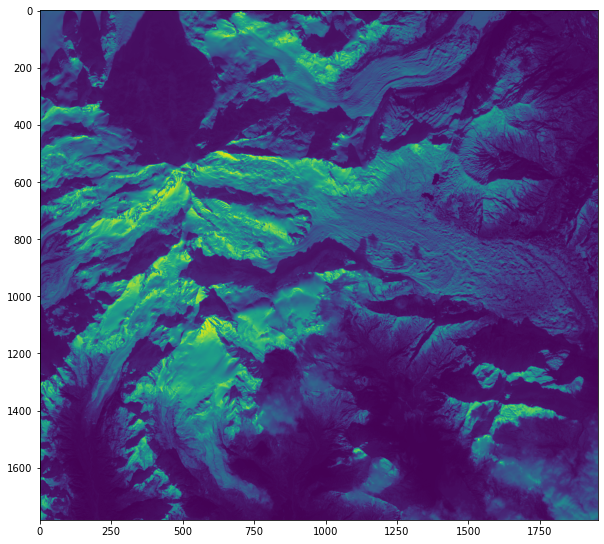

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
ax.imshow(bands["red"].data)

In [14]:
# reading spatial metadata at pixel level - only for one band
_s2_df = s2_df.loc[[REF_BND]]

# get sun angles
sun_zn, sun_az = read_sun_angles_s2(WORK_DIR)

# get mean sun angles
sun_zn_mean, sun_az_mean = read_mean_sun_angles_s2(WORK_DIR)

# get sensor configuration
det_stack = read_detector_mask(WORK_DIR, _s2_df, geoTransform)

# get sensor viewing angles
view_zn, view_az = read_view_angles_s2(WORK_DIR,
                                       det_stack=det_stack, 
                                       boi_df=_s2_df)

sun_zn = sun_zn[bbox_idx[0]:bbox_idx[1], bbox_idx[2]:bbox_idx[3]]
sun_az = sun_az[bbox_idx[0]:bbox_idx[1], bbox_idx[2]:bbox_idx[3]]
view_zn = view_zn[bbox_idx[0]:bbox_idx[1], bbox_idx[2]:bbox_idx[3]]
view_az = view_az[bbox_idx[0]:bbox_idx[1], bbox_idx[2]:bbox_idx[3]]

In [15]:
# create shadow enhanced imagery
Si, Ri = entropy_shade_removal(
    bands["blue"].data,
    bands["red"].data,
    bands["nir"].data,
    a=SHADE_REMOVAL_ANGLE,
)

In [16]:
# construct shadowing and shading
Shw = make_shadowing(dem.data, sun_az_mean, sun_zn_mean)
Shd = make_shading(dem.data, sun_az, sun_zn)

In [17]:
# matching
print('start matching')
sample_I, sample_J = get_coordinates_of_template_centers(dem.data, WINDOW_SIZE)
sample_X, sample_Y = pix2map(geoTransform, sample_I, sample_J)
match_X, match_Y, match_score = match_pair(Shd, Si,
                                           stable.data, stable.data,
                                           geoTransform, geoTransform,
                                           sample_X, sample_Y,
                                           temp_radius=WINDOW_SIZE,
                                           search_radius=WINDOW_SIZE,
                                           correlator='ampl_comp',
                                           subpix='moment',
                                           metric='peak_entr')  # 'robu_corr'

dY, dX = sample_Y - match_Y, sample_X - match_X
IN = ~np.isnan(dX)

Slp, Asp = get_template_aspect_slope(dem.data,
                                     sample_I, sample_J,
                                     WINDOW_SIZE)

PURE = np.logical_and(IN, Slp<20)
dx_coreg, dy_coreg = np.median(dX[PURE]), np.median(dY[PURE])
print(dx_coreg, dy_coreg)

Si_ort = compensate_ortho_offset(Si, dem.data, dx_coreg, dy_coreg,
                                 view_az, view_zn, geoTransform)
Ri_ort = compensate_ortho_offset(Ri, dem.data, dx_coreg, dy_coreg,
                                 view_az, view_zn, geoTransform)

start matching


100%|██████████| 13542/13542 [00:12<00:00, 1106.01it/s]
/data/volume_2/fnattino/dhdt/dhdt/preprocessing/acquisition_geometry.py:198: RuntimeWarning: invalid value encountered in arccos
  slope_bar = np.arccos(np.sum(n_sub[...,-1] * kernel))  # slope


0.7523871911689639 0.10617139795795083


In [18]:
# classify shadow-enhanced image
classification = ms.morphological_chan_vese(
    Si_ort, 30, init_level_set=Shw, lambda1=1, lambda2=1,
    smoothing=0, albedo=Ri_ort, mask=stable
)

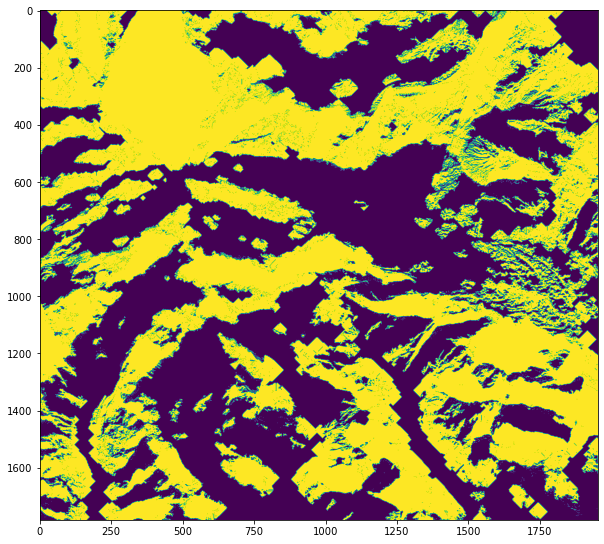

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
ax.imshow(classification)

In [20]:
shadow_image_to_list(
    classification, geoTransform, WORK_DIR, 
    Zn=sun_zn_mean, Az=sun_az_mean, bbox=bbox_idx
)

/data/volume_2/fnattino/dhdt/dhdt/input/read_sentinel2.py:987: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  rec_time = np.datetime64(att.text, 'ns')


Save output:
* shadow enhanced image (`Si_ort`)
* albedo (`Ri_ort`)
* artificial shadow from DEM (`Shw`)
* artificial shading from DEM (`Shd`)
* classification (`classification`)
* stable mask (`stable`) / or maybe cloud_mask?
* connectivity file (`conn.txt`)